In [1]:
setwd('/data/jzr5814/repositories/DnDs-visualization/test_dataset/')

In [2]:
#install.packages("tidyverse")
#install.packages("viridis")
#install.packages("patchwork")
#install.packages("ggraph")
#install.packages("igraph")

In [3]:
library(tidyverse)
library(viridis)
library(patchwork)
library(ggraph)
library(igraph)
library(dplyr)


── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Loading required package: viridisLite


Attaching package: ‘igraph’


The following objects are masked from ‘package:lubridate’:

    %--%, union


The following objects are masked from ‘package:dplyr’:

    as_data_frame, groups, union


The following objects are masked from ‘package:purrr’:

    compose, simplify


The following object is masked from ‘package:tidyr’:

    crossing


The following object is masked from ‘package:tibble’:

    as_data_frame


The following

In [4]:
library(dplyr)
# Load the datasets
taxonomy <- read.csv('marinus_taxonomy.csv')
dnds <- read.csv('dnds_constant_15.csv')

# Drop rows where column dNdS_ratio or column dNdS_ratio_constant is NA
dnds <- dnds %>%
  filter(!is.na(dNdS_ratio) & !is.na(dNdS_ratio_constant)) %>%
  select(X, A, B, dNdS_ratio_constant)

#dnds has the pairwise estimates between A and B

In [5]:
# Add a root column to the taxonomy data, reshape the data into long format
taxonomy_long <- taxonomy %>%
  select(custom_fasta_name, phylum, class, order, family, genus, species) %>%
  mutate(Root = "Root") %>%

  # Create hierarchical relationships
  pivot_longer(cols = c(Root, phylum, class, order, family, genus, species, custom_fasta_name),
               names_to = "level",
               values_to = "name")%>%
  mutate(genome_id = rep(taxonomy$custom_fasta_name, each = 8))


# Create hierarchical relationships
hierarchy <- taxonomy_long %>%

  # sorting taxomomic lelvel within each genome ("genome_id")
  arrange(genome_id, match(level, c("Root", "phylum", "class", "order", "family", "genus", "species", "custom_fasta_name"))) %>%
  group_by(genome_id) %>%

  # from = lag(name): Take the value from the previous row in the column "name" and assigns it to a new column called from, 
  # to = name: Set the value in column "to" the value in the name column.
  mutate(from = lag(name), to = name)  %>%
  filter(!is.na(from)) %>%
  select(from, to) %>%
  distinct() %>%
  ungroup() %>%
  distinct(from, to)

Adding missing grouping variables: `genome_id`


Number of valid edges (with positions): 420 


Warning message in geom_edge_link(data = valid_edges, aes(x = x_from, y = y_from, :
“Ignoring unknown parameters: `edge_size`”


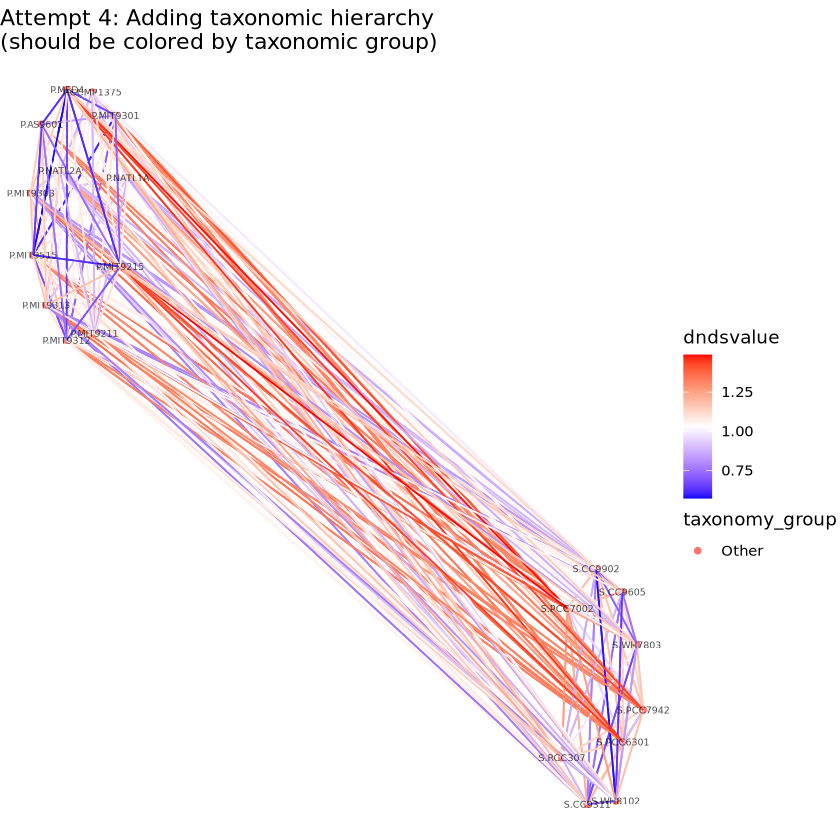

In [6]:

set.seed(399) 
# Assuming 'hierarchy' and 'dnds' are already loaded and processed
# Create the graph object
vertices <- data.frame(name = unique(c(as.character(hierarchy$from), as.character(hierarchy$to))), value = runif(31)) 
mygraph <- graph_from_data_frame(hierarchy, vertices = vertices)

connect <- dnds %>%
  rename(from = A, to = B, dndsvalue = dNdS_ratio_constant) %>%
  select(from, to, dndsvalue)

from <- match(connect$from, vertices$name)
to <- match(connect$to, vertices$name)

# Add taxonomy group to vertices (nodes) in the graph
taxonomy_long <- taxonomy_long %>%
  mutate(taxonomy_group = case_when(
    level == "phylum" ~ "Phylum",
    level == "family" ~ "Family",
    level == "genus" ~ "Genus",
    TRUE ~ "Other"
  ))

# Match taxonomy group to nodes
V(mygraph)$taxonomy_group <- taxonomy_long$taxonomy_group[match(V(mygraph)$name, taxonomy_long$name)]

# Create the layout using a force-directed layout ('fr')
layout_data <- create_layout(mygraph, layout = 'fr')

# Filter layout_data for the nodes present in the connect data (edges)
layout_data <- layout_data %>%
  filter(name %in% c(connect$from, connect$to))

# Handle missing nodes by adding random positions if necessary
missing_nodes <- unique(c(connect$from, connect$to)) %>%
  setdiff(layout_data$name)

if (length(missing_nodes) > 0) {
  missing_nodes_data <- data.frame(
    name = missing_nodes,
    x = runif(length(missing_nodes), min = -1, max = 1),
    y = runif(length(missing_nodes), min = -1, max = 1)
  )
  
  layout_data <- bind_rows(layout_data, missing_nodes_data)
  cat("Added missing nodes:", missing_nodes, "\n")
}

# Create edges_with_positions
edges_with_positions <- connect %>%
  left_join(layout_data, by = c("from" = "name")) %>%
  rename(x_from = x, y_from = y) %>%
  left_join(layout_data, by = c("to" = "name")) %>%
  rename(x_to = x, y_to = y) %>%
  mutate(con.id = paste(from, to, sep = "_"))

valid_edges <- edges_with_positions %>%
  filter(!is.na(x_from) & !is.na(y_from) & !is.na(x_to) & !is.na(y_to))

cat("Number of valid edges (with positions):", nrow(valid_edges), "\n")

# Plot the graph with the updated layout
p <- ggraph(layout_data) + 
  geom_node_point(aes(x = x, y = y, color=taxonomy_group)) +  # Color nodes by taxonomy group
  geom_edge_link(data = valid_edges, aes(x = x_from, y = y_from, 
                                         xend = x_to, yend = y_to, 
                                         color = dndsvalue,
                                         group = con.id), size = 1) +  # Color edges by dNdS
  scale_edge_color_gradientn(colors = c("blue", "white", "red")) +  # Edge color gradient for dNdS
  geom_node_text(aes(x = x, y = y, label = name), size = 2, alpha = 0.7) +  # Node labels
  theme_void() + # Clean the plot theme
  ggtitle("Attempt 4: Adding taxonomic hierarchy\n(should be colored by taxonomic group)")

ggsave("/data/jzr5814/repositories/DnDs-visualization/Hierarchical_Edge_Bundling_tree/attempt4.pdf", plot = p, width = 10, height = 8, units = "in", device = cairo_pdf)


# Display the plot
print(p)
